## Modelo Realista Simplificado

Modelo simplificado baseado no modelo realista do notebook "Modelo Realista - Geertsma".
Autor: André Defendi Arelaro (andre.arelaro@gmail.com)

CONVENÇÃO DE EIXOS CARTESIANOS: X cresce para norte, Y cresce para leste e Z cresce para baixo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import compaction as cp
import andre_mestrado as am
import pickle

/home/andre/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
#Carregando os dados de entrada. Eles estão em um arquivo do tipo easting, northing, z, densidades e batimetria.
#Amostragem de 50 m nas direções horizontais e 25 m na direção vertical. Formato de grid 3D extendido.
#As coordenadas variam primeiro na direção E-W, depois N-S e em z por último.

#Lendo o arquivo de entrada
arq_entra = pickle.load(open('Mod_real/dens_simplif.pickle', 'rb'))

easting = arq_entra['y'] #direção leste-oeste
northing = arq_entra['x'] #direção norte-sul
z = arq_entra['z'] #profundidade
dens_base = arq_entra['dens_base'] #densidades em diferentes tempos. Base é 2002.
dens_2013 = arq_entra['dens_2013']
bat = arq_entra['bat'] #batimetria da região (posições das medidas)

np.min(dens_base), np.max(dens_base), type(dens_base)

(0.0, 2.64, numpy.ndarray)

In [3]:
#Informações sobre os modelos de densidade
N = np.size(easting) #número de dados de cada umas das variáveis lidas
east_min, east_max = np.min(easting), np.max(easting) #limites dos modelos na direção leste-oeste
nort_min, nort_max = np.min(northing), np.max(northing) #limites dos modelos na direção norte-sul
z_min, z_max = np.min(z), np.max(z) #limites dos modelos na direção vertical

#Intervalos espaciais
de, dn, dz = 50., 50., 25.
N, east_min, east_max, nort_min, nort_max, z_min, z_max, np.min(bat), np.max(bat)

(1950312, 0.0, 13250.0, 0.0, 14050.0, 2712.0, 3337.0, 1158.24, 1505.29)

In [4]:
#Discretizando os modelos geológicos em meshs de prismas retangulares
Ne = int((east_max - east_min)/de) #Número de prismas na direção leste-oeste
Nn = int((nort_max - nort_min)/dn) #Número de prismas na direção norte-sul
Nz = int((z_max - z_min)/dz) #Número de prismas na direção vertical
print Nn, Ne, Nz

dens_back = 2640. #densidade do background em kg/m³
#Tranformando as densidades em kg/m³ e substituindo os valores nulos pelos do background
dens_base2 = np.zeros(N)
for i in range(N):
    if (dens_base[i] == 0.):
        dens_base2[i] = dens_back
    else:
        dens_base2[i] = dens_base[i]*1000

print np.min(dens_base2), np.max(dens_base2)

dens_2013_2 = np.zeros(N)
for i in range(N):
    if (dens_2013[i] == 0.):
        dens_2013_2[i] = dens_back
    else:
        dens_2013_2[i] = dens_2013[i]*1000

print np.min(dens_2013_2), np.max(dens_2013_2)

281 265 25
2084.7000000000003 2640.0
2084.2999999999997 2640.0


In [5]:
#Valor de batimetria constante para os pontos de observação
bat_med = np.round(np.mean(bat))
bat_med

1338.0

In [6]:
#Lendo o arquivo das pressões de poros. Não preciso pegar as coordenadas porque são iguais dos arquivos anteriores
arq_entra = pickle.load(open('Mod_real/poros_simplif.pickle', 'rb'))

#pressão de poros em diferentes tempos, em MPascal. Base é 2002. Já passo para a geometria de grid 3D.
poros_base = np.reshape(arq_entra['poros_base'], (Nz+1, Ne+1, Nn+1)) 
poros_2013 = np.reshape(arq_entra['poros_2013'], (Nz+1, Ne+1, Nn+1)) 

np.min(poros_base), np.max(poros_base), np.min(poros_2013), np.max(poros_2013)

(0.0, 30.98, 0.0, 34.19)

In [7]:
#passando a densidade para a geometria de grid 3D também.
dens_base = np.reshape(dens_base2, (Nz+1, Ne+1, Nn+1)) 
dens_2013 = np.reshape(dens_2013_2, (Nz+1, Ne+1, Nn+1))

In [8]:
Ne2, Nn2, Nz2 = 13, 14, 2 #Nova quantidade de prismas em cada direção 
de2, dn2, dz2 = 1000., 1000., 300. #dimensões dos prismas

#Número de celas no grid 3D que cabem dentro de um prisma novo em cada direção
ne = int(de2/de)
nn = int(dn2/dn)
nz = int(dz2/dz)

print ne, nn, nz
#Novos limites máximos do modelo
east_max2, nort_max2, z_max2 = 13000., 14000., 3312.

20 20 12


In [9]:
#Criando um modelo novo decimado a partir do original. O valor das propriedades no centro de cada novo prisma é 
# igual à média dos valores das propriedades que estavam no modelo original na mesma região.
mod_novo = np.zeros((Ne2*Nn2*Nz2, 7))

cont = 0
for i in range(Nz2):
    for j in range(Ne2):
        for k in range(Nn2):
            dens_base_novo = np.mean(dens_base[i*nz:(i+1)*nz, j*ne:(j+1)*ne, k*nn:(k+1)*nn])
            dens_2013_novo = np.mean(dens_2013[i*nz:(i+1)*nz, j*ne:(j+1)*ne, k*nn:(k+1)*nn])
            poros_base_novo = np.mean(poros_base[i*nz:(i+1)*nz, j*ne:(j+1)*ne, k*nn:(k+1)*nn])
            poros_2013_novo = np.mean(poros_2013[i*nz:(i+1)*nz, j*ne:(j+1)*ne, k*nn:(k+1)*nn])
            
            #montando o novo modelo no formato east, north, z, densidades e pressão de poros. Coordenadas e valores
            # no centro dos prismas
            mod_novo[cont,0] =  j*de2 + de2/2.
            mod_novo[cont,1] =  k*dn2 + dn2/2.
            mod_novo[cont,2] =  i*dz2 + dz2/2. + z_min
            mod_novo[cont,3] =  dens_base_novo
            mod_novo[cont,4] =  dens_2013_novo
            mod_novo[cont,5] =  poros_base_novo
            mod_novo[cont,6] =  poros_2013_novo
            
            cont +=1
            
print "Limites dos valores de densidade base: ", np.min(mod_novo[:, 3]), np.max(mod_novo[:, 3])
print "Limites dos valores de densidade 2013: ", np.min(mod_novo[:, 4]), np.max(mod_novo[:, 4])
print "Limites dos valores de pressão base: ", np.min(mod_novo[:, 5]), np.max(mod_novo[:, 5])
print "Limites dos valores de pressão 2013: ", np.min(mod_novo[:, 6]), np.max(mod_novo[:, 6])

Limites dos valores de densidade base:  2400.08625 2640.0
Limites dos valores de densidade 2013:  2400.7778125 2640.0
Limites dos valores de pressão base:  0.0 4.853554166666666
Limites dos valores de pressão 2013:  0.0 5.587989583333333


In [10]:
#Como a média da pressão é muito baixa, adiciono um valor constante nos prismas com valores não nulos
for i in range(Ne2*Nn2*Nz2):
    if mod_novo[i, 5] != 0.:
        mod_novo[i, 5] += 30.
    if mod_novo[i, 6] != 0.:
        mod_novo[i, 6] += 30.
        
print "Limites dos valores de pressão base: ", np.min(mod_novo[:, 5]), np.max(mod_novo[:, 5])
print "Limites dos valores de pressão 2013: ", np.min(mod_novo[:, 6]), np.max(mod_novo[:, 6])

Limites dos valores de pressão base:  0.0 34.85355416666667
Limites dos valores de pressão 2013:  0.0 35.58798958333333


In [11]:
#Salvando o arquivo
#np.savetxt("Val/modelo_simplificado.xyz", mod_novo, fmt='%.1f, %.1f, %.1f, %.4f, %.4f, %.4f, %.4f')

## Calculando os deslocamentos vertical e radial no plano y-z (North = 8km)

In [12]:
#Pontos de observação
shape = (100, 80)
east_yz = np.linspace(east_min, east_max2, shape[0])
z_yz = np.linspace(0, 4000., shape[1])
east_grid_yz, z_grid_yz = np.meshgrid(east_yz, z_yz)
east_yz = east_grid_yz.ravel()
z_yz = z_grid_yz.ravel()
north_yz = np.ones_like(east_yz)*8000
coord_yz = np.vstack([east_yz, north_yz, z_yz])
coord_yz

array([[    0.        ,   131.31313131,   262.62626263, ...,
        12737.37373737, 12868.68686869, 13000.        ],
       [ 8000.        ,  8000.        ,  8000.        , ...,
         8000.        ,  8000.        ,  8000.        ],
       [    0.        ,     0.        ,     0.        , ...,
         4000.        ,  4000.        ,  4000.        ]])

In [13]:
pois = 0.25 #razão de Poisson
young = 3300. #módulo de Young em MPa

#organizando os pontos do modelo do reservatório para entrar na função de cálculo do deslocamento e do stress
mod = am.prism_layer([east_min, east_max2, nort_min, nort_max2, z_min, z_max2], (Ne2,Nn2,Nz2))
print mod.shape, "\n", mod

(364, 6) 
[[    0.  1000.     0.  1000.  3012.  2712.]
 [    0.  1000.  1000.  2000.  3012.  2712.]
 [    0.  1000.  2000.  3000.  3012.  2712.]
 ...
 [12000. 13000. 11000. 12000.  3312.  3012.]
 [12000. 13000. 12000. 13000.  3312.  3012.]
 [12000. 13000. 13000. 14000.  3312.  3012.]]


In [14]:
#Calculando o deslocamento nas três direções no plano yz
inicio_date = datetime.datetime.now()

# Deslocamento N-S
d_x1 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_x1')
d_x2 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_x2')
d_xz2 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_xz2')
dn_yz = d_x1 + (3 - 4*pois)*d_x2 + d_xz2

# Deslocamento E-W
d_y1 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_y1')
d_y2 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_y2')
d_yz2 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_yz2')
de_yz = d_y1 + (3 - 4*pois)*d_y2 + d_yz2

# Deslocamento vertical
d_z1 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_z1')
d_z2 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_z2')
d_zz2 = cp.field_component(coord_yz, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='d_zz2')
dz_yz = d_z1 + (3 - 4*pois)*d_z2 + d_zz2

fim_date = datetime.datetime.now()

print "Tempo total de cálculo: ", fim_date - inicio_date
print "Deslocamento em norte-sul: ", np.min(dn_yz), np.max(dn_yz), np.shape(dn_yz)
print "Deslocamento em leste-oeste: ", np.min(de_yz), np.max(de_yz), np.shape(de_yz)
print "Deslocamento vertical: ", np.min(dz_yz), np.max(dz_yz), np.shape(dz_yz)

Tempo total de cálculo:  0:00:25.063911
Deslocamento em norte-sul:  -0.012613037878021935 0.012160747591525191 (8000,)
Deslocamento em leste-oeste:  -0.020344635464762482 0.0266215841236588 (8000,)
Deslocamento vertical:  -0.015587715411765384 0.03526721671876357 (8000,)


In [15]:
displacement_horizontal = np.sqrt(de_yz**2 + dn_yz**2) #deslocamento horizontal
print "Deslocamento horizontal: ", np.min(displacement_horizontal), np.max(displacement_horizontal), np.shape(
    displacement_horizontal)

Deslocamento horizontal:  0.000102126574795919 0.02879038140788713 (8000,)


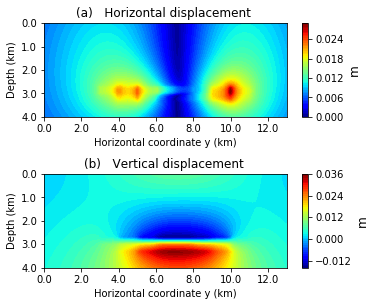

In [16]:
# Plot the displacement fields
y = np.linspace(east_min, east_max2, shape[0])/1000. #em km
z = np.linspace(0, 4000., shape[1])/1000. #em km

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(5.33,4.33))

#ax[0].set_aspect("equal")
img = ax[0].contourf(y, z, displacement_horizontal.reshape(shape[::-1]),
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=1.00, ticks=[0.,0.006, 0.012,0.018, 0.024])
cb.set_label('m', rotation=90, fontsize=12)
ax[0].set_title("(a)   Horizontal displacement ")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].invert_yaxis()
ax[0].set_xlabel("Horizontal coordinate y (km)")
ax[0].set_ylabel("Depth (km)")

#ax[1].set_aspect("equal")
img = ax[1].contourf(y, z, dz_yz.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=1.00, ticks=[-0.012, 0., 0.012, 0.024, 0.036])
cb.set_label('m', rotation=90, fontsize=12)
ax[1].set_title("(b)   Vertical displacement ")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].invert_yaxis()
ax[1].set_xlabel("Horizontal coordinate y (km)")
ax[1].set_ylabel("Depth (km)")
plt.tight_layout(True)
#plt.savefig('Figuras/jubarte/Figure_Displacement.png', dpi=600)
#plt.savefig('../manuscript/Fig/Figure_Displacement.png', dpi=600)

## Stress na superfície livre (z=0 m)

In [17]:
# Define computation points on the plane z = 0m
shape = (60, 60)
y = np.linspace(east_min, east_max2, shape[0])
x = np.linspace(nort_min, nort_max2, shape[1])
y, x = np.meshgrid(y, x)
y = y.ravel()
x = x.ravel()
z = np.zeros_like(x)
coord2 = np.vstack([y, x, z])

In [18]:
inicio_date = datetime.datetime.now()

# Compute the x-component of stress
s_xz1 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_xz1')
s_xz2 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_xz2')
s_xzz2 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_xzz2')
stress_x = s_xz1 + s_xzz2 + s_xz2
stress_x *= young/(1 + pois)

# Compute the y-component of stress
s_yz1 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_yz1')
s_yz2 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_yz2')
s_yzz2 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_yzz2')
stress_y = s_yz1 + s_yzz2 + s_yz2
stress_y *= young/(1 + pois)

# Compute the z-component of stress
s_zz1 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_zz1')
s_zz2 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_zz2')
s_zzz2 = cp.field_component(coord2, mod, mod_novo[:,6]-mod_novo[:,5], pois, young, kernel='s_zzz2')
stress_z = s_zz1 + s_zzz2 - s_zz2
stress_z *= young/(1 + pois)

fim_date = datetime.datetime.now()

print "Tempo total de cálculo: ", fim_date - inicio_date
print "Deslocamento em norte-sul: ", np.min(stress_x), np.max(stress_x), np.shape(stress_x)
print "Deslocamento em leste-oeste: ", np.min(stress_y), np.max(stress_y), np.shape(stress_y)
print "Deslocamento vertical: ", np.min(stress_z), np.max(stress_z), np.shape(stress_z)

Tempo total de cálculo:  0:00:08.233150
Deslocamento em norte-sul:  -2.719738090338833e-16 2.473759722456184e-16 (3600,)
Deslocamento em leste-oeste:  -2.826654824106007e-16 2.884655405169245e-16 (3600,)
Deslocamento vertical:  -3.83642397635154e-17 3.3542504711270293e-17 (3600,)


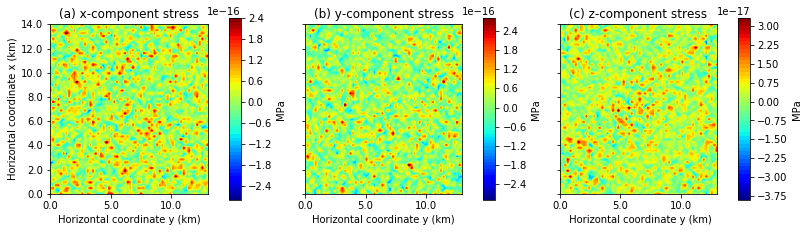

In [19]:
# Plot the results on a map
y = np.linspace(east_min, east_max2, shape[0])/1000. #em km
x = np.linspace(nort_min, nort_max2, shape[1])/1000. #em km

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(11.33, 5.33))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, x, stress_x.reshape(shape),
                  60, cmap="jet")

cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.10, shrink=0.5)
cb.set_label('MPa', rotation=90, fontsize=10)

ax[0].set_title("(a) x-component stress")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].set_xlabel("Horizontal coordinate y (km)")
ax[0].set_ylabel("Horizontal coordinate x (km)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, x, stress_y.reshape(shape),  
                  60, cmap="jet")

cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.10, shrink=0.5)
cb.set_label('MPa', rotation=90, fontsize=10)

ax[1].set_title("(b) y-component stress")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].set_xlabel("Horizontal coordinate y (km)")
#ax[1].set_ylabel("x (m)")

ax[2].set_aspect("equal")
img = ax[2].contourf(y, x, stress_z.reshape(shape),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[2], aspect=15, pad=0.10, shrink=0.5)
cb.set_label('MPa', rotation=90, fontsize=10)

ax[2].set_title("(c) z-component stress")

ax[2].set_xticklabels(ax[2].get_xticks())
ax[2].set_yticklabels(ax[2].get_yticks())
ax[2].set_xlabel(" Horizontal coordinate y (km)")
#ax[2].set_ylabel("x (m)")

plt.tight_layout(True)
#plt.savefig('Figuras/jubarte/Figure_Null_stress.png', dpi=600)
#plt.savefig('../manuscript/Fig/Figure_Null_stress.png', dpi=600)